<a href="https://colab.research.google.com/github/Glifoyle/test-repo/blob/master/5_CNN_v5_PyTorch_Fmnist_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 目的：CNNの「学習」を理解する

### 概要：CNN（Convolutional Neural Network：畳み込みニューラルネットワーク）を用いて，Fashion-MNISTのファッション商品画像を分類する

<br>
&copy; 2021-2024 Hiro Kimura
<br>


## ポイント：

-  データには，**Fashion-MNIST**ファッション商品画像のデータセットを用いる
-  PyTorchフレームワークの機能（自動微分等）を用いる
-  **GPU**（Graphics Processing Unit）を用いる
-  学習モデルには，**CNN**（Convolutional Neural Network）モデルを用いる
-  損失関数には正解ラベルと予測値との**交差エントロピー誤差**を用いる
-  最適値の探索には，勾配降下法（SGD：確率的勾配降下法）を用いる





# 実習の準備をする

1. GPU使用の設定をする
1. タイムゾーンを東京に変更する
1. Google Driveをマウントする
1. 作業ディレクトリ（フォルダ）を作成する
1. PyTorchフレームワークやライブラリを導入する


## GPUの設定
- Google Colabの設定
  1. 上部のメニューバーから
  1. **ランタイム／ランタイムのタイプを変更**
  1. ハードウエアアクセラレータで，**GPU**を選択
  1. 保存
  - **GPUの使用には時間制限がある**ので注意する

- プログラムの設定（プログラム内で必要の都度）
  - デバイスの設定
  - データの送信

In [ ]:
import torch

# CPU / GPU の設定
# GPUを使用する際は，まず最初に，ランタイム > ランタイムタイプの変更 > GPU  > 保存

# GPUの設定であればcuda，そうでなければcpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# 割り当てられたGPUを調べる

!nvidia-smi

Tue Apr 16 02:30:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# # 割り当てられたGPUの機種を調べる
# torch.cuda.get_device_name(0)

## タイムゾーンを東京に変更する

In [ ]:
# 現在の設定を確認
!date

Tue Apr 16 02:30:54 AM UTC 2024


In [ ]:
# 設定を変更
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/Asia/Tokyo /etc/localtime

!date

Tue Apr 16 11:30:57 AM JST 2024


## Google Driveをマウントする

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 作業用フォルダを作成する

In [ ]:
# # 作業用フォルダを作成
# !mkdir -p '/content/drive/MyDrive/practice/chap_cnn'
# %cd '/content/drive/MyDrive/practice/chap_cnn'
# !pwd

In [ ]:
# 作業用フォルダ（作業ディレクトリ）を作成
import os

chap_dir = "/content/drive/MyDrive/practice/chap_cnn"
if not os.path.exists(chap_dir): # ディレクトリが存在していなければ
    # os.mkdir(chap_dir)
    os.makedirs(chap_dir) # ディレクトリを，途中のディレクトリも含めて，作成する

os.chdir(chap_dir) # 今回の作業ディレクトリに移動する
os.getcwd() # 現在の作業ディレクトリを表示する

'/content/drive/MyDrive/practice/chap_cnn'

## PyTorchのインストール
- 既に導入済み

In [ ]:
# pythonのバージョン確認
# ! python --version

In [ ]:
# torch, torchvisionをインストール
# ! pip install torch==1.9.0 torchvision

# ! pip install torch torchvision

# 「学習」の手順

1. データを準備する
  - データの読み込み
  - データの前処理
  - データの分割
  - データローダの作成
1. モデルを定義する
1. モデルを訓練する
  - データをGPUに転送
  - 損失関数と最適化手法を設定
  - 訓練を実施
1. 学習済みモデルを性能評価する

# データを準備する

Fashion-MNISTデータセットは，
-  ラベル$0～9$のついたファッション商品画像データ
-  6万枚の訓練用データ（画像と正解ラベル）
-  1万枚のテスト用データ（画像と正解ラベル）
-  画像は8ビットグレースケール（0：白～255：黒）
-  画像は幅：28 x 高さ：28ピクセル（768ピクセル）

> Fashion-MNIST: a Novel Image Dataset for Benchmarking > Machine Learning Algorithms. Han Xiao, Kashif Rasul,
> Roland Vollgraf. arXiv:1708.07747

<!-- 参考
PyTorch公式サンプルコード<br>
https://github.com/pytorch/examples/blob/master/mnist/main.py -->


## データを読み込み（ネットワークから）

- データを読み込み，マウントしたgoogle drive 内に保存する
- データのダウンロードには，サーバやネットワークの負荷状況により，**数分程度**の時間がかかることがある
- データダウンロードとともに前処理（テンソル変換や標準化処理）も行う

In [ ]:
# データを格納するディレクトリを作成する

data_dir = "./dataset"
if not os.path.exists(data_dir): # ディレクトリが存在していなければ
    os.makedirs(data_dir) # ディレクトリを，途中のディレクトリも含めて，作成する

# 現在の作業ディレクトリを確認する
!pwd
!ls -F

/content/drive/MyDrive/practice/chap_cnn
dataset/  Lenna_test_image_gray.png


## データの前処理

- データのダウンロード
  - 元のデータが訓練用とテスト用に分割されているので，別々にダウンロードする
    - trainval: 訓練用
    - test:     テスト用

- データダウンロード後に，自動的にデータの前処理も行う
  - Tensor型への変換
    - 画素値データ（0～255）をTensor型データに変換する
      - 正規化処理（Min-Max処理）
    - データ順の変換（C-H-W順に）
    - 最終的なTensor型データは，概ね-1.0～1.0 の範囲



In [ ]:
# FMNIST
from torchvision.datasets import MNIST, FashionMNIST
from torchvision import datasets, transforms
import os

# データをダウンロードし，Tensorに変換
# データの前処理の定義
# Tensorに変換だけ（自動的にmin-max変換とデータのC-H-Wへの並べ替えも）
fmnist_transform = transforms.Compose([transforms.ToTensor(), ])

# データのダウンロードと前処理
# FashionMNISTフォルダが存在する場合は download = False にする
fmnist_trainval = FashionMNIST(root='./dataset', train=True, download=True, transform=fmnist_transform)
fmnist_test = FashionMNIST(root='./dataset', train=False, download=True, transform=fmnist_transform)


In [ ]:
# # MNIST
# from torchvision.datasets import MNIST
# from torchvision import datasets, transforms
# import os

# # データをダウンロードし，Tensorに変換し，平均 0.1307，標準偏差 0.3081 で標準化する

# # データの前処理の定義
# transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# # データのダウンロードと前処理
# mnist_trainval = MNIST(root='./dataset', train=True, download=True, transform=transform)
# mnist_test = MNIST(root='./dataset', train=False, download=True, transform=transform)

# # # データのダウンロード済の場合は前処理だけ
# # mnist_trainval = MNIST(root='./dataset', train=True, download=False, transform=transform)
# # mnist_test = MNIST(root='./dataset', train=False, download=False, transform=transform)


In [ ]:
# データセットのタイプを確認する
print(type(fmnist_trainval))
print(type(fmnist_test))

# データセットの長さを確認する
# 訓練データ数：60,000件，テストデータ数：10,000件
print(len(fmnist_trainval))
print(len(fmnist_test))

<class 'torchvision.datasets.mnist.FashionMNIST'>
<class 'torchvision.datasets.mnist.FashionMNIST'>
60000
10000


### 画像を表示して確認する
- 画像データはテンソル型に変換済み

<class 'torch.Tensor'>
torch.Size([1, 28, 28])
正解ラベル：9


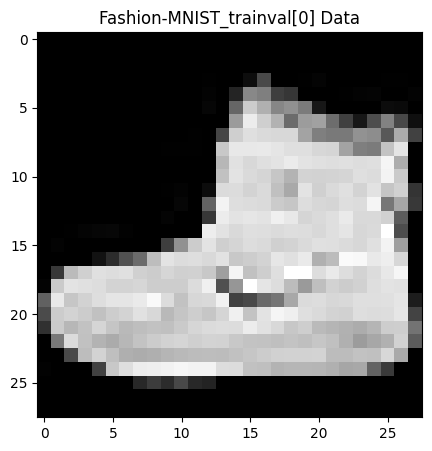

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# データの内容を確認する
# x_0 は最初の画像データ，t_0 は最初の教師ラベル（答えの数値）
# 1枚の画像（手書きの数字）は 28 x 28 ピクセルで構成されている
x_0, t_0 = fmnist_trainval[0]

# 画像データの型とサイズを確認する
print(type(x_0))  # Tensor型
print(x_0.size()) # Channel（色数）, Hight（縦）, Width（横）
img = x_0.reshape(28, 28)

# 正解ラベルを表示する
print('正解ラベル：{}'.format(t_0))

# 図の大きさをインチ単位で指定する
plt.figure(figsize=(5,5))

plt.title("Fashion-MNIST_trainval[0] Data")

# 画像を白黒で表示する
plt.imshow(img, cmap='gray')

plt.show()

### 画像表示を工夫する - Fashion-MNISTクラスの機能を利用する
#### FashionMNIST クラスの属性：
- FashionMNIST.classes (list): クラス名一覧
- FashionMNIST.class_to_idx (dict): クラス名、値がクラス ID の辞書
- FashionMNIST.data (Tensor): 画像一覧
- FashionMNIST.targets (Tensor): ラベル一覧

#### クラス一覧：
| クラスID | クラス名 (英語) | クラス名 (日本語)|
|:-:|:--|:--|
| 0	| T-shirt/top	| Tシャツ/トップス |
| 1	| Trouser	| パンツ/ボトムズ |
| 2	| Pullover	| セーター |
| 3	| Dress	| ドレス |
| 4	| Coat	| コート |
| 5	| Sandal	| サンダル |
| 6	| Shirt	| シャツ |
| 7	| Sneaker	| スニーカー |
| 8	| Bag	| バッグ |
| 9	| Ankle | boot	ブーツ|

In [ ]:
# クラス名リストを取得する
class_list = fmnist_trainval.classes # リスト
print(class_list)

# クラス名からラベルIDを取得する辞書を作成する
class_id_dict = fmnist_trainval.class_to_idx # 辞書 f(クラス名)->ラベルID
print(class_id_dict)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


In [ ]:
# ラベルIDからクラス名を取得する辞書（逆引き辞書）を作成する
id_values = class_id_dict.values()
id_class_dict = {}
for id in id_values: # 0,1,2....9
  id_class_dict[id] = class_list[id] # 'T-shirt/top', 'Trouser',,,,,'Ancle boot'
print(id_class_dict)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


In [ ]:
# 各クラスのサンプルを一枚ずつ取得する
import numpy as np

class_ids, sample_indices = np.unique(fmnist_trainval.targets, return_index=True)
print(f'クラス数：{len(class_ids)}, 画像データ数：{len(sample_indices)}')

クラス数：10, 画像データ数：10


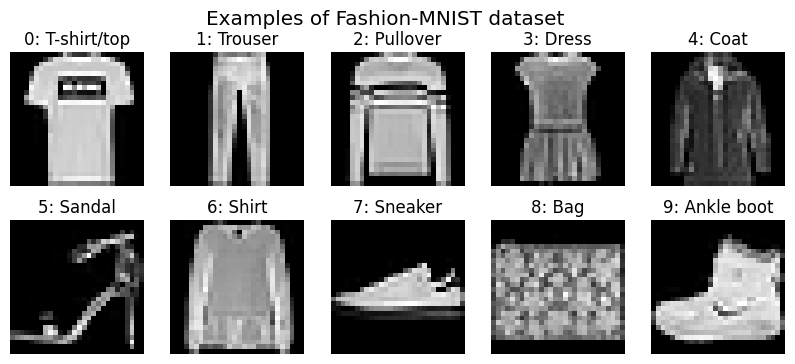

In [ ]:
# 各クラス一枚ずつサンプル画像を表示する
# 画像表示領域
fig = plt.figure(figsize=(10, 4))

# 画像全体のタイトル
fig.suptitle("Examples of Fashion-MNIST dataset", fontsize="x-large")

for i in class_ids: # クラス番号順に0～9
    img = fmnist_trainval.data[sample_indices[i]] # 画像データ
    class_name = fmnist_trainval.classes[i] # クラス名

    # 画像表示エリアを2行5列に分割し，左上から順番に0～9
    ax = fig.add_subplot(2, 5, i + 1) # i+1番目の領域に
    ax.set_title(f"{i}: {class_name}") # クラス番号：クラス名の形式を
    ax.set_axis_off()
    ax.imshow(img, cmap="gray") # 白黒画像として

plt.show() # 表示する

## データセットの分割
- 通常は，訓練用，検証用，テスト用に**3分割**する（最低でも，訓練用，テスト用に**2分割**にする（下記<注意>を参照））
- 訓練用 = 55,000枚
- 検証用 = 5,000枚（訓練データ 60,000枚の内の5,000枚），訓練状況の検証用
- テスト用 = 10,000枚，モデル性能のテスト用
- 検証用は，訓練が**過学習になってないか**，訓練状況の確認に使用
- テスト用は，学習済みモデルの**性能を確認**するために使用<br>

**<注意>**<br>
**（カンニング禁止）**：一度でも訓練で使用したデータはテストに使ってはいけない

In [ ]:
# ライブラリ
import torch

# 乱数シードを固定して再現性を確保する
torch.manual_seed(24)

In [ ]:
from torch.utils.data import random_split

# 訓練データを，train (55,000 images), val (5,000 images)に分割
# 訓練：train，検証：val stands for validation
fmnist_train, fmnist_val = random_split(fmnist_trainval, [55000, 5000])

In [ ]:
# データセットの長さを確認する
# train: 55,000, val: 5,000, test: 10,000
print(len(fmnist_train))
print(len(fmnist_val))
print(len(fmnist_test))

55000
5000
10000


## データローダの作成
- データローダとは，指定したミニバッチ数のデータを提供してくれるもの
- データは，（訓練データと教師ラベルの組）x ミニバッチ数 で構成される
- shuffle=True を指定すると，ランダムにミニバッチ数のデータを選択して提供してくれる
- shuffle=False を指定すると，毎回同じ順番でデータを提供してくれる


In [ ]:
from torch.utils.data import DataLoader

# The dataloaders handle shuffling, batching, etc...
# ミニバッチ長を100とする（100枚の画像毎に訓練する）
b_size = 100

fmnist_train_loader = DataLoader(fmnist_train, batch_size=b_size, shuffle=True)
fmnist_val_loader = DataLoader(fmnist_val, batch_size=b_size, shuffle=False)
fmnist_test_loader = DataLoader(fmnist_test, batch_size=b_size, shuffle=False)

# モデルを定義する

- ニューラルネットワークモデル（入力層，中間層（多層），出力層）
- 出力ニューロンは，10個（10種類の数値（0～9）のクラス分類確率）
- 活性化関数は，ReLU

## CNNモデル

- 多層
  - コンボリューション層を2層
  - ドロップアウト層
  - maxプーリング層
  - 活性化関数
    - ReLU 関数（relu()）
- 最終出力
  - ノード数は10（10クラス分類）
  - 活性化関数
    - 対数ソフトマックス関数（log_softmax()）
- マニュアル
  -  [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
  - [Dropout2d](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html?highlight=dropout2d)

In [ ]:
'''モデル1の定義'''
# -----------------
# 2L-CNN
# カーネルサイズ: 3
# Dropoutなし
# BatchNormなし
# -----------------
import torch
from torch import nn
import torch.nn.functional as F

class MNISTClassifier_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) # in-ch, out-ch, kernel, stride
        self.conv2 = nn.Conv2d(32, 64, 3, 1) # in-ch, out-ch, kernel, stride
        # self.dropout1 = nn.Dropout2d(0.25)
        # self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        # x = self.dropout2(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        # x = F.softmax(x, dim=1)
        return x

In [ ]:
# '''モデル2の定義'''
# # [提出課題1]で使用するモデル
# # # -----------------
# # # 2L-CNN
# カーネルサイズ: 5
# # # Dropoutなし
# # # BatchNormあり
# # # -----------------
# import torch
# from torch import nn
# import torch.nn.functional as F

# class MNISTClassifier_CNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(1, 16, kernel_size=5, padding=2),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(2))
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(16, 32, kernel_size=5, padding=2),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(2))
#         self.fc = nn.Linear(7 * 7 * 32, 10)

#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         x = F.log_softmax(x, dim=1)
#         # x = F.softmax(x, dim=1)
#         return x

### MLPモデル

In [ ]:
# '''モデル3の定義'''
# [提出課題2]で使用するモデル
# # -----------------
# # 3L-MLP
# # -----------------
# import torch
# from torch import nn
# import torch.nn.functional as F

# class MNISTClassifier_MLP(nn.Module):

#   def __init__(self):
#     super(MNISTClassifier_MLP, self).__init__()

#     # mnist images have (1, 28, 28) of shape : (channels, width, height)
#     self.layer_1 = nn.Linear(28 * 28, 128)  # 入力：784，入力層出力：128
#     self.layer_2 = nn.Linear(128, 256)      # 中間層入力：128，中間層出力：256
#     self.layer_3 = nn.Linear(256, 10)       # 出力層入力：256，出力：10

#   def forward(self, x):
#     # 入力はバッチサイズ分の画像データ
#     batch_size, channels, width, height = x.size()

#     # b: batch（バッチ長）, c: channel（カラー数）, w: width（横）, h: height（縦）
#     # (b, c, w, h) = (100, 1, 28, 28) -> (100, 1*28*28)
#     x = x.view(batch_size, -1) # (100, 768)

#     # layer 1
#     x = self.layer_1(x)
#     # x = torch.relu(x)
#     x = F.relu(x)

#     # layer 2
#     x = self.layer_2(x)
#     # x = torch.relu(x)
#     x = F.relu(x)

#     # layer 3
#     x = self.layer_3(x)

#     # probability distribution over labels => log_softmax()
#     x = torch.log_softmax(x, dim=1)
#     # x = F.softmax(x, dim=1)

#     return x

# 訓練の準備をする


### モデルの初期化

In [ ]:
# 学習モデルの初期化

# model = MNISTClassifier_MLP()
model = MNISTClassifier_CNN() # モデルパラメータ値の初期化

model = model.to(device) # モデルのパラメータ値を演算デバイスに送る


In [ ]:
# モデルの構造を再確認する
from torchsummary import summary

summary(model, (1, 28, 28)) # C, H, W = 1, 28, 28の画像を入力した場合

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Linear-3                  [-1, 128]       1,179,776
            Linear-4                   [-1, 10]           1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 4.58
Estimated Total Size (MB): 5.03
----------------------------------------------------------------


### 損失関数と最適化手法を設定する
- 損失関数は，交差エントロピー誤差（$loss=-\sum_{k}^{n} t_{k}\log y_k$）
- 最適化手法は，SGDで最小化

### 損失関数（交差エントロピー誤差）
- 教師ラベル$t$は **one-hotベクトル**（一つの要素だけが1で，他の要素は全て0のベクトル）で表現する<br>
例えば，$5$であれば，0から始まるので6番目の要素だけが1で，$$t = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]$$<br>
- 予測結果 $y$ は，softmax関数を施した$0～1$の実数値を要素とするベクトルで表現する<br>
softmax関数を施した出力の合計は$1$になる（つまり各要素は確率とみなすことができる）<br>
例えば，$$y = [0.01, 0.0, 0.08, 0.02, 0.0, 0.6, 0.18, 0.04, 0.02, 0.05]$$
- 損失関数には交差エントロピー誤差を用いる<br>
$$ loss = -\sum_{n=1}^n t_n\log y_n $$
ここで，$log$は自然対数を表す．交差エントロピー誤差は，結果的に $t$ が1の要素の自然対数値だけになる．
例えば，上記の場合には，教師ラベルが$1$の6番目の項だけが残るので，$ -1*\log 0.6 = 0.51$ と計算できる



In [ ]:
# 損失関数（交差エントロピー誤差）
import torch.nn as nn

criterion = nn.CrossEntropyLoss()

In [ ]:
# 最適化手法（SGD）
from torch import optim

# 学習率 lr は試行錯誤する必要がある．
eta = 0.01
optimizer = optim.SGD(model.parameters(), lr=eta) # SGD

## 訓練と検証用の関数

- 作業フォルダに **train_valid.py** が存在することを確認する
    - 存在しない場合は，以下のセルを実行してアップロードする
    - またはファイルアイコンから作業ディレクトリを開いて、パソコンからドラッグ&ドロップする


In [ ]:
from google.colab import files

uploaded = files.upload()

In [ ]:
# 作業フォルダを確認する
!ls -F

dataset/  Lenna_test_image_gray.png  train_valid.py


In [ ]:
# 関数を読み込む
from train_valid import train, valid

# # 訓練用の関数（1エポックの処理）を定義
# def train(model, criterion, optimizer, train_loader, device, scheduler=None):
#       return epoch_loss, epoch_acc # 1エポックの1データ当たりのロスと正解率

# # 検証用の関数（1エポックの処理）を定義
# def valid(model, criterion, optimizer, valtest_loader, device):
#       return val_loss, val_acc # 1エポックの1データ当たりのロスと正解率


# 訓練を実施する

## データをGPUに送る
1.   Colabランタイムの設定変更（この教材の**最初に設定済み**）

  *   ランタイム > ランタイムタイプの変更 > GPU > 保存 を選択
<br><t>（注意）ランタイムが再起動するので，全てのセルを再実行する

2.   プログラムの修正

  *   パラメータ（ニューラルネットワークモデル）をGPUに送る
  *   データ（画像と正解ラベル）をGPUに送る






In [ ]:
# 演算デバイスを確認する

# print(device)

In [ ]:
# モデルのパラメータを演算デバイスに送る
# モデル生成時に送信済み

# model = model.to(device) # モデルのパラメータを演算デバイスに送る

次のセルのCNNによる訓練は時間がかかるので注意すること
- GPUで，5～10秒/epoch 程度かかる．（50 epochでは 7分程度かかる）
- CPUで，2.5分/epoch 程度かかる．（後で，発展課題として，2エポック程度で試してみる）

In [ ]:
# 訓練を実施する
import copy

# 訓練の長さ
EPOCHS = 50 # GPU
# EPOCHS = 2 # CPUで試す場合

# 訓練と検証の状況を記録する空の入れ物
train_acc_list = []
train_loss_list = [] # 訓練ロス
val_loss_list = [] # 検証ロス
val_acc_list = [] # 検証の正解率

best_model_wts = copy.deepcopy(model.state_dict()) # 現在のパラメータ値をコピー
best_acc = 0.0 # epochのベスト精度を記録
best_epoch = 0 # ベスト精度が出た時のepoch数

for epoch in range(EPOCHS):
    # エポックの処理
    # 訓練
    loss, acc = train(model, criterion, optimizer, fmnist_train_loader, device) # Fashin-MNIST
    # loss, acc = train(model, criterion, optimizer, mnist_train_loader, device) # MNIST

    # 検証
    val_loss, val_acc = valid(model, criterion, optimizer, fmnist_val_loader, device) # Fashio-MNIST
    # val_loss, val_acc = valid(model, criterion, optimizer, mnist_val_loader, device) # MNIST

    print('epoch %d, train_loss: %.2f train_acc: %.2f val_loss: %.2f val_acc: %.2f' % (epoch, loss, acc, val_loss, val_acc))

    # deep copy the model
    # 精度が一番良かったモデルを保存する
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        best_epoch = epoch

    # 訓練と検証の状況を記録
    train_acc_list.append(acc)
    train_loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

# 精度が一番良いモデルのパラメータ値をファイルに保存する
torch.save(best_model_wts, './cnn_model1_wts_fmnist.pkl')
print(f'Best Acc（検証データ）：{best_acc:.2f} at epoch {best_epoch}')

epoch 0, train_loss: 0.97 train_acc: 0.67 val_loss: 0.66 val_acc: 0.74
epoch 1, train_loss: 0.60 train_acc: 0.77 val_loss: 0.55 val_acc: 0.81
epoch 2, train_loss: 0.54 train_acc: 0.80 val_loss: 0.51 val_acc: 0.81
epoch 3, train_loss: 0.50 train_acc: 0.81 val_loss: 0.50 val_acc: 0.82
epoch 4, train_loss: 0.48 train_acc: 0.82 val_loss: 0.45 val_acc: 0.84
epoch 5, train_loss: 0.45 train_acc: 0.84 val_loss: 0.47 val_acc: 0.82
epoch 6, train_loss: 0.44 train_acc: 0.84 val_loss: 0.45 val_acc: 0.83
epoch 7, train_loss: 0.42 train_acc: 0.85 val_loss: 0.45 val_acc: 0.83
epoch 8, train_loss: 0.41 train_acc: 0.85 val_loss: 0.39 val_acc: 0.86
epoch 9, train_loss: 0.39 train_acc: 0.86 val_loss: 0.39 val_acc: 0.86
epoch 10, train_loss: 0.38 train_acc: 0.86 val_loss: 0.38 val_acc: 0.86
epoch 11, train_loss: 0.37 train_acc: 0.87 val_loss: 0.37 val_acc: 0.86
epoch 12, train_loss: 0.36 train_acc: 0.87 val_loss: 0.35 val_acc: 0.87
epoch 13, train_loss: 0.35 train_acc: 0.87 val_loss: 0.35 val_acc: 0.87
ep

### 訓練の様子をグラフ表示

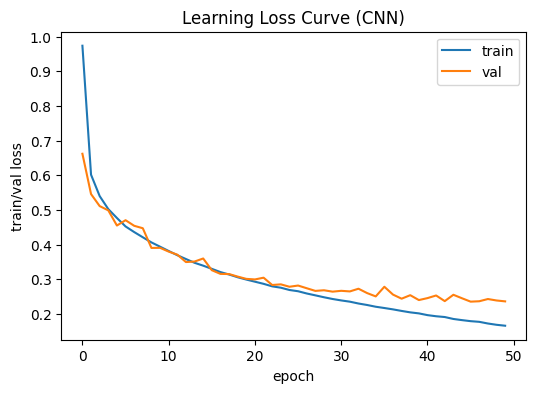

In [ ]:
# 損失が減少していく様子をグラフ表示する
%matplotlib inline
from matplotlib import pyplot as plt

# 図の大きさをインチ単位で指定する
plt.figure(figsize=(6, 4))

plt.title('Learning Loss Curve (CNN)')
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('train/val loss')
plt.show()

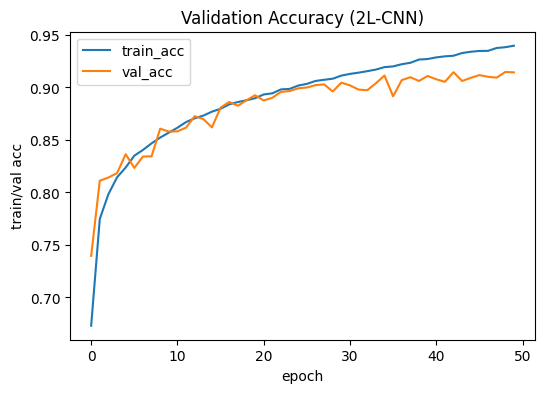

検証データの最高精度：91.5 % at エポック 48


In [ ]:
# 正解率が上昇していく様子をグラフ表示する

# 図の大きさをインチ単位で指定する
plt.figure(figsize=(6, 4))

plt.title('Validation Accuracy (2L-CNN)') # タイトル
plt.plot(train_acc_list, label='train_acc')
plt.plot(val_acc_list, label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('train/val acc')

plt.show()
print(f'検証データの最高精度：{best_acc*100:.1f} % at エポック {best_epoch}')
# print('正解率（最終Epoch）：',val_acc_list[-1]*100, '%')

# 学習済みモデルを評価する

### テストデータでモデルの予測性能を評価する

In [ ]:
# 検証データで最高精度を出したパラメータ値を使用する
# model.load_state_dict(torch.load("./cnn_model1_wts_fmnist.pkl"))

# モデルのパラメータをGPUに送信する
# model = model.to(device)

In [ ]:
# テストを実施する

# テスト
test_loss, test_acc = valid(model, criterion, optimizer, fmnist_test_loader, device) # Fashion-MNIST
# test_loss, test_acc = valid(mnist_test_loader) # MNIST
# print('test_loss: %.3f test_acc: %.3f' % (test_loss, test_acc))
print('正解率（テストデータの平均精度）: {:.2f}'.format(test_acc))


正解率（テストデータの平均精度）: 0.91


# まとめ
1. 画像フィルタ処理が理解できた
  - カーネル
  - 畳み込み（Convolution）処理

2. CNN（Convolutional Neural Network）による学習モデルを構築し，Fashion-MNIST画像を精度良く分類できた
  - GPUの利用法が理解できた
  - CNNモデルの構造と定義方法が理解できた
  - CNNモデルでは画像フィルタ処理のカーネルをパラメータとして学習することが理解できた
  - MLPモデルと比べると，CNNモデルは訓練時間が長くかかることが理解できた
<!-- - （MNIST画像で比較した場合，）MLPモデルと比べると，CNNモデルは画像認識の精度が良くなる（99%程度）ことが理解できた -->


# [提出課題1]

- 以下の手順に従って，CNNのモデル2を用いて学習し分類を実施してみる．

  1. CNNモデルで，'''モデル1の定義'''とコメントされているセルの定義をコメントにする
    1. そのセルをクリックし，Ctrl-A で全体を選択し，
    1. Ctrl-/ で選択範囲をコメント文にする

  1. CNNモデルで，'''モデル2の定義'''とコメントされているセルのコメントを外す
    1. そのセルをクリックし，Ctrl-A で全体を選択し，
    1. Ctrl-/ で選択範囲をコメント文にする

  1. 以下の手順でプログラムを再実行する
    1. メニューバーの，ランタイム ／ ランタイムを再起動
    1. メニューバーの，ランタイム ／ すべてのセルを実行

  1. テストデータでモデルの予測性能を評価する
    1. test_acc の値を小数第二位までで答えよ

# [提出課題2]

- 以下の手順に従って，CNNに代わり，MLP（全結合型ネットワーク）を用いて学習し分類を実施してみる．

  1. CNNモデルで，'''モデル2の定義'''とコメントされているセルの定義をコメントにする
    1. そのセルをクリックし，Ctrl-A で全体を選択し，
    1. Ctrl-/ で選択範囲をコメント文にする
  
  1. MLPモデルで，'''モデル3の定義'''とコメントされているセルのコメントを外す
    1. そのセルをクリックし，Ctrl-A で全体を選択し，
    1. Ctrl-/ で選択範囲をコメント文にする
  
  1. モデルの初期化で，以下のように```model = MNISTClassifier_CNN()```の行の先頭に#をつけてコメント文にし，```model = MNISTClassifier_MLP()```の行頭の#を外して実行文にする
  ```
  # 学習モデルの初期頭
model = MNISTClassifier_MLP()
# model = MNISTClassifier_CNN() # モデルパラメータ値の初期化
  ```

  1. 以下の手順でプログラムを再実行する
    1. メニューバーの，ランタイム ／ ランタイムを再起動
    1. メニューバーの，ランタイム ／ すべてのセルを実行

  1. テストデータでモデルの予測性能を評価する
    1. test_acc の値を小数第二位までで答えよ


# 発展課題

- CPUで訓練した場合の学習時間を確認してみる．
  1.  ランタイム／ランタイムのタイプを変更で，ハードウエアアクセラレータをnoneに設定する<br>（ランタイムの設定を変更すると，プログラムは最初から実行しなおさないといけない）
  1.  エポック数（epochs）を 2 程度に設定する
  1.  訓練を実行する




